In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import defaultdict, OrderedDict
from tqdm import tqdm_notebook as tqdm, tnrange as trange

plt.style.use('seaborn')

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. stopwords
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [2]:
# nltk stopwords
stopwords = {'it', 'before', "you're", 'wouldn', "hasn't", 'again', 'just', "you'd", 'only', "wouldn't", "isn't", 'no', 'yourself', 'them', 'in', 's', "aren't", 'because', 'ourselves', 'more', "couldn't", "shan't", "shouldn't", 'shan', 't', 'needn', "hadn't", 'both', 'such', 'below', 'out', 'my', "haven't", 'there', 'off', 'few', 'against', 'each', 'can', 'yourselves', 'some', 'further', 'if', 'under', 'over', 'theirs', 'his', 'herself', 'been', 'her', 'than', "you've", 'into', 'have', 'aren', 'and', 'then', 'whom', 'having', 'the', 'by', 'itself', 'him', 'up', 'be', "wasn't", 'me', 'of', 'haven', 'they', "mightn't", 'our', 'are', 'how', "weren't", 'couldn', 'too', "should've", 'until', 'weren', "that'll", 'a', 'when', "doesn't", 'which', 'here', 'was', 'hers', 'ain', 'mightn', 'those', 'himself', 'or', 'while', 'i', 'yours', 'from', 'once', 'after', 'does', 'its', 'to', 'you', 'myself', 'don', 'shouldn', 'most', 'that', 'mustn', 'same', "it's", 'what', 'any', 'did', 'isn', 'she', 'these', 'with', 'during', "needn't", 'your', 'their', 'being', 'on', 'above', 've', 'won', 'down', "she's", 're', 'this', 'do', 'hasn', 'had', 'so', 'other', 'an', 'were', 'hadn', 'themselves', 'will', 'as', 'for', 'at', 'd', 'm', 'but', 'ma', 'didn', 'll', 'not', "won't", 'ours', 'who', 'through', 'all', 'now', 'o', 'nor', "mustn't", "you'll", 'where', 'doesn', 'y', 'doing', 'why', 'between', "didn't", 'he', 'we', 'wasn', 'has', 'very', "don't", 'own', 'about', 'is', 'should', 'am'}
len(stopwords)

179

In [3]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [4]:
def clean_word(w):
    if w in stopwords:
        return '#STOP#'
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.strip().lower()

### I/O

In [5]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [6]:
def read_train_file(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            sentence.append(clean_word(word))
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels


def read_val_file(val_filename):
    with open(val_filename, 'r') as f:
        lines = f.readlines()
        
    sentence = []
    sentences = []
    for word in lines:
        if word == '\n':
            sentences.append(sentence)
            sentence = []
        else:
            sentence.append(clean_word(word))
    return sentences

### Train data

In [7]:
dataset = 'EN'
train_filename = f'data/{dataset}/train'

observations, states = parse(train_filename)

In [8]:
train_sentences, train_labels = read_train_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['rt', '#AT#', '#PUNC#', 'encore', '#PUNC#'], ['O', 'O', 'O', 'B-INTJ', 'O'])

### Validation data

In [9]:
val_filename = f'data/{dataset}/dev.in'
val_sentences = read_val_file(val_filename)
val_sentences[0][:5]

['no', 'saints', 'r', '#PUNC#', 'buch']

## Encoding

In [10]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [11]:
token_mapping = {}
for word in observations:
    if observations[word] >= 1:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

2461

In [12]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]

tokens = [tokenize(token_mapping, sentence) for sentence in train_sentences]
tokens[0][:5]

[0, 1, 2, 3, 2]

Tokenize then one-hot-encode each sentence.

In [13]:
inputs = [[one_hot_encode(token, len(token_mapping)) for token in sentence] for sentence in tokens]
inputs = [np.asarray(ls) for ls in inputs]
len(inputs), inputs[0].shape

(551, (25, 2461, 1))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [14]:
state_mapping = {state: i for i, state in enumerate(states)}
state_mapping

{'O': 0,
 'B-INTJ': 1,
 'B-PP': 2,
 'B-NP': 3,
 'I-NP': 4,
 'B-VP': 5,
 'B-PRT': 6,
 'I-VP': 7,
 'B-ADJP': 8,
 'B-SBAR': 9,
 'B-ADVP': 10,
 'I-INTJ': 11,
 'B-CONJP': 12,
 'I-CONJP': 13,
 'I-ADVP': 14,
 'I-ADJP': 15,
 'I-SBAR': 16,
 'I-PP': 17}

In [15]:
encoded_labels = [[state_mapping[state] for state in label] for label in train_labels]
encoded_labels[0][:5]

[0, 0, 0, 1, 0]

In [16]:
labels = [[one_hot_encode(label, len(state_mapping)) for label in sentence] for sentence in encoded_labels]
labels = [np.asarray(ls) for ls in labels]
len(labels), labels[0].shape

(551, (25, 18, 1))

## RNN
$$
    a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)} \\
    h^{(t)} = \text{tanh}(a^{(t)}) \\
    \\
    o^{(t)} = c + Vh^{(t)} \\
    \hat{y}^{(t)} = \text{softmax}(o^{(t)})
$$

In [17]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Initialization

In [18]:
np.random.seed(0)

rnn_size = 128
# input
U = np.random.normal(0, 0.1, size=[rnn_size, len(token_mapping)])
# hidden layer
W = np.random.normal(0, 0.1, size=[rnn_size, rnn_size])
b = np.ones(shape=[rnn_size, 1]) * 0.1
# output
V = np.random.normal(0, 0.1, size=[len(state_mapping), rnn_size])
c = np.ones(shape=[len(state_mapping), 1]) * 0.1

In [19]:
model = (U, W, b, V, c)  # time for some unpacking magic

### Forward

In [20]:
def forward(*args, x):
    """
    Compute the outputs at each time step.
    Note that in the forward function, we only store y_ at each time step.
    """
    y_ = []
    # initialize h_1
    h = np.tanh(b + U.dot(x[0]))
    o = c + V.dot(h)
    y_.append(softmax(o))
    # iterate for [h_t, .., h_n]
    for i in range(1, len(x)):
        h = np.tanh(b + W.dot(h) + U.dot(x[i]))
        o = c + V.dot(h)
        y_.append(softmax(o))
    return np.array(y_)

y_ = forward(*model, x=inputs[0])
y_.shape

(25, 18, 1)

In [21]:
np.argmax(y_, axis=1).flatten()

array([17,  3, 13,  1,  3,  3,  8, 12, 12, 11, 12, 12, 14, 11,  3, 13,  4,
       12,  5,  4,  5, 14,  3, 12,  3])

## Backward
`<insert derived backpropagation equations here>`

In [22]:
weights = np.asarray(list(states.values()))
weights = 1 / weights
weights /= np.max(weights)
weights = weights.reshape(-1, 1)
weights

array([[9.12825194e-04],
       [7.78210117e-03],
       [2.79329609e-03],
       [7.22543353e-04],
       [1.05042017e-03],
       [1.50715901e-03],
       [2.35294118e-02],
       [3.29489292e-03],
       [1.25786164e-02],
       [2.81690141e-02],
       [5.18134715e-03],
       [2.27272727e-02],
       [1.00000000e+00],
       [1.00000000e+00],
       [3.92156863e-02],
       [3.27868852e-02],
       [5.00000000e-01],
       [3.33333333e-01]])

In [23]:
def jacobian(h):
    """
    Returns the Jacobian of tanh(h).
    """
    diag_elems = (1 - h**2).flatten()
    return np.diag(diag_elems)
    

def backward(*args, x, y):
    assert len(x) == len(y)
    n = len(x)
    if n <= 1:
        return np.nan, (0, 0, 0, 0, 0)
    
    # feedforward
    h_1 = np.tanh(b + U.dot(x[0]))
    h = [h_1]
    for i in range(1, n):
        h_t = np.tanh(b + W.dot(h[-1]) + U.dot(x[i]))
        h.append(h_t)

    o = [c + V.dot(h_t) for h_t in h]
    
    # backprop
    do = [softmax(o[i]) - (y[i]*weights) for i in range(n)]
    
    dh_n = V.T.dot(do[-1])  # h_n has no (t+1) gradient
    dh = [dh_n]
    for i in range(n-2, -1, -1):
        dh_t = W.T.dot(jacobian(h[i+1])).dot(dh[0]) + V.T.dot(do[i])
        dh.insert(0, dh_t)
        
    dc = np.mean(do, axis=0)
    dV = np.mean([do[i].dot(dh[i].T) for i in range(n)], axis=0)
    
    delta_h = [jacobian(h[i]).dot(dh[i]) for i in range(n)]  # propagated error term of h
    db = np.mean(delta_h, axis=0)
    dW = np.mean([delta_h[i].dot(h[i-1].T) for i in range(1, n)], axis=0)  # t=1 has no prev
    dU = np.mean([delta_h[i].dot(x[i].T) for i in range(n)], axis=0)
    
    assert dc.shape == c.shape
    assert dV.shape == V.shape
    assert db.shape == b.shape
    assert dW.shape == W.shape
    assert dU.shape == U.shape

    grad = (dU, dW, db, dV, dc)
    
    # compute loss
    y_ = [softmax(o_t) for o_t in o]
    xent = [-np.log(y_[i] + 1e-8) * y[i] for i in range(n)]
    loss = np.mean(np.sum(xent, axis=1))  # sum softmax CE for each word, then take mean across all words
    return loss, grad
        
for i in trange(len(inputs)):
    backward(*model, x=inputs[i], y=labels[i])

## Training

In [24]:
def predict(logits):
    states = list(state_mapping)
    indices = np.argmax(logits, axis=1)
    return [states[int(i)] for i in indices]
            
def compute_accuracy():
    accuracies = []
    for i in trange(len(inputs), leave=False):
        logits = forward(*model, x=inputs[i])
        y_true = predict(labels[i])
        y_pred = predict(logits)
        accuracies.append(np.mean(np.array(y_pred) == np.array(y_true)))
    return np.mean(accuracies)

In [25]:
lr = 0.0005
n_epochs = 100

In [26]:
%%script false
# overfitting test
x, y = inputs[0], labels[0]

losses = []
for i in trange(n_epochs):
    loss, grad = backward(*model, x=x, y=y)
    
    losses.append(loss)
    for error, weight in zip(grad, model):
        weight -= lr * error

In [27]:
losses  = []
accuracies = []
for i in trange(n_epochs):
    for j in trange(len(inputs), leave=False):
        x, y = inputs[j], labels[j]
        loss, grad = backward(*model, x=x, y=y)
        
        losses.append(loss)
        for error, weight in zip(grad, model):
            weight -= lr * error
    accuracies.append(compute_accuracy())

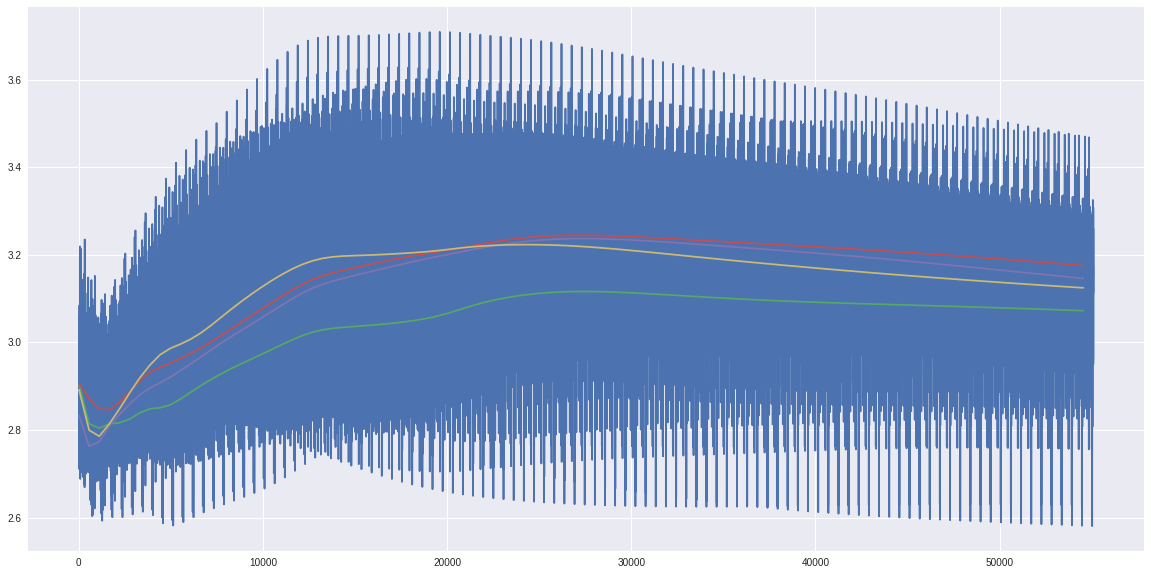

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(losses)), losses)  # overall training loss

interval = len(inputs)
for i in range(4):
    plt.plot(np.arange(len(losses))[i::interval], losses[i::interval]);  # loss of one sentence over each epoch

(10, 0.1589907863797054)

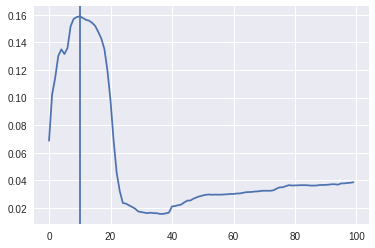

In [33]:
plt.plot(np.arange(n_epochs), accuracies)
plt.axvline(x=np.argmax(accuracies))
np.argmax(accuracies), np.max(accuracies)

## Prediction

In [30]:
def predict(logits):
    states = list(state_mapping)
    indices = np.argmax(logits, axis=1)
    return [states[int(i)] for i in indices]

In [31]:
y_pred = predict(forward(*model, x=inputs[0]))
y_true = predict(labels[0])

In [32]:
for _pred, _true in zip(y_pred, y_true):
    print(_pred, _true, sep='\t')

B-NP	O
I-NP	O
B-INTJ	O
I-INTJ	B-INTJ
I-INTJ	O
I-INTJ	O
I-INTJ	B-PP
I-INTJ	B-NP
I-INTJ	I-NP
I-INTJ	O
I-INTJ	B-NP
I-INTJ	O
I-INTJ	B-NP
I-INTJ	I-NP
I-INTJ	B-PP
I-INTJ	B-NP
I-INTJ	I-NP
I-INTJ	I-NP
I-INTJ	I-NP
I-INTJ	I-NP
I-INTJ	I-NP
I-INTJ	O
I-INTJ	B-NP
I-INTJ	I-NP
I-INTJ	O
